In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
# load enviroment
import gym
env = gym.make('LunarLander-v2')

In [3]:
# observation vector
env.seed(42)
obs = env.reset()
obs

array([-0.00499964,  1.4194578 , -0.506422  ,  0.37943238,  0.00580009,
        0.11471219,  0.        ,  0.        ], dtype=float32)

In [4]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

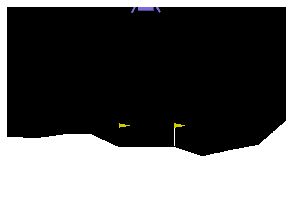

In [5]:
plot_environment(env)
plt.show()

In [6]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=20):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [7]:
# create Double DQN

n_outputs = 4

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(150, activation="elu", input_shape=[8]),
    keras.layers.Dense(120, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [8]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [9]:
from collections import deque

def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [10]:
# model hyperparameters
batch_size = 32
discount_rate = 0.98
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [17]:
replay_memory = deque(maxlen=8000)

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

n_steps = 200
n_episodes = 2000

for episode in range(n_episodes):
    episode_reward = 0
    obs = env.reset()
    
    for step in range(n_steps):
        epsilon = max(1 - episode / 1900, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        episode_reward += reward
        if done:
            break
            
    rewards.append(episode_reward)
    
    if episode_reward > best_score:
        best_weights = model.get_weights()
        best_score = episode_reward
    print("\rEpisode: {}, Reward: {}, eps: {:.3f}".format(episode, episode_reward, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
        
    if episode == 50 and episode == 100 and episode == 150 and episode == 200:
        target.set_weights(model.get_weights())
        
    # We will do soft updates at each step:
    if episode > 200:
        target_weights = target.get_weights()
        online_weights = model.get_weights()
        for index in range(len(target_weights)):
            target_weights[index] = 0.95 * target_weights[index] + 0.05 * online_weights[index]
        target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 1999, Reward: 21.160926661815438, eps: 0.0100

In [18]:
# check the best score
best_score

172.838520264415

Text(0, 0.5, 'Sum of rewards')

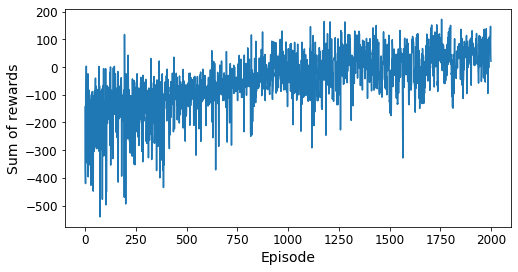

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)

In [13]:
# test trained agent
env.seed(42)
state = env.reset()

frames = []
test_rewards = 0

for step in range(1000):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    test_rewards += reward
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

In [21]:
model.save('model_best_score.h5')

In [14]:
# make gif file
import PIL

image_path = "lunar_lander.gif"
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:-1]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)